# HW5: Model Predictive Control

> - Full Name: **Payam Taebi**
> - Student ID: **400104867**


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/MPC.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/MPC.ipynb)

## Overview
Here the goal is to use **MPC** for [gymnasium environments](https://gymnasium.farama.org/).
More specificly we focus on the [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/) environment and try to solve it using [mpc.pytorch](https://locuslab.github.io/mpc.pytorch/).




In [ ]:
# @title Imports

# Stuff you (might) need
import random
import numpy as np
import gymnasium as gym

import torch
from torch import nn
import torch.autograd
from tqdm.notebook import trange
import math

# Stuff used for visualization
from matplotlib import pyplot as plt
from gymnasium.wrappers import RecordVideo
import base64
import imageio
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# @title Visualization Functions

def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)


def plot_results(rewards, actions):
    plt.plot(rewards, label='Rewards')
    plt.plot(actions, label='Actions')
    plt.legend()
    plt.title(f"Total reward: {sum(rewards):.2f}")
    plt.show()

# Explore the Environment (25 points)

To better understand the environment, let's first see what a random agent does.

In [ ]:
# Initialize the pendulum environment with video recording enabled
env = gym.make('Pendulum-v1', render_mode='rgb_array')

# Create a directory to save the video
video_directory = "random_videos"
env = RecordVideo(env, video_directory)

# Set the number of steps to record
num_steps = 500

# Reset the environment to get the initial state
state, info = env.reset()

for _ in (pbar := trange(num_steps)):
    # Sample a random action
    action = env.action_space.sample()

    # Step the environment: note that gymnasium returns terminated and truncated flags.
    state, reward, terminated, truncated, info = env.step(action)

    # Render the environment (video recording is handled by the RecordVideo wrapper)
    frame = env.render()

    # If the episode is done (either terminated or truncated), reset the environment
    if terminated or truncated:
        state, info = env.reset()

    pbar.set_description(f'Action = {action[0]:.2f} | Reward = {reward:.2f}')

# Close the environment to finalize the video
env.close()

# Show the video
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')


  0%|          | 0/500 [00:00<?, ?it/s]

The goal of the [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/) environment in [Gymnasium](https://gymnasium.farama.org/) is to swing a pendulum to an upright position and keep it balanced there.
In this environment, you control a torque that can be applied to the pendulum.
The objective is to apply the right amount of torque to swing the pendulum up and maintain its upright position.

## Simulation Tools

Both the `angle_normalize` function and the `PendulumDynamics` class are fundamental components for accurately simulating, analyzing, and controlling the pendulum system.
They ensure consistency in angle representation and provide a realistic model of the pendulum's behavior, enabling effective control strategies.

We use the `angle_normalize` function for:

*   **Consistency**: When dealing with angles, it's important to keep them within a standard range to ensure consistency in calculations.
*   **Handling Wrapping**: Angles can wrap around when they exceed $2\pi$ or drop below $-2\pi$. Normalizing angles helps avoid confusion and errors that can arise from angle wrapping.


And we use the `PendulumDynamics` class for:

*   **Modeling Physical Behavior**: The `PendulumDynamics` class models the physical behavior of the pendulum.
*   **Simulation and Control**: This class allows us to simulate the pendulum's response to different actions, which is crucial for designing and testing control algorithms.
*   **Optimization**: Understanding the dynamics of the pendulum helps in optimizing the control inputs. The class encapsulates the physics involved, enabling us to apply control techniques like Model Predictive Control (MPC) to achieve the desired behavior.




In [ ]:
class PendulumDynamics(nn.Module):
    def forward(self, state, action):
        th = state[:, 0].view(-1, 1)
        thdot = state[:, 1].view(-1, 1)

        g = 10 # default value of the environment (not 9.81)
        m = 1
        l = 1
        dt = 0.05

        u = action
        u = torch.clamp(u, -2, 2)

        newthdot = thdot + (-3 * g / (2 * l) * torch.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
        newth = th + newthdot * dt
        newthdot = torch.clamp(newthdot, -8, 8)

        state = torch.cat((angle_normalize(newth), newthdot), dim=1)
        return state


def angle_normalize(x):
    return (((x + math.pi) % (2 * math.pi)) - math.pi)

# Model Predictive Control (50 points)

[mpc.pytorch](https://locuslab.github.io/mpc.pytorch/) is a library that provides a fast and differentiable [Model Predictive Control](https://en.wikipedia.org/wiki/Model_predictive_control) (MPC) solver for PyTorch. It was developed by researchers at [LocusLab](https://locuslab.github.io/) and is designed to integrate seamlessly with PyTorch, allowing for efficient and flexible control of dynamic systems.

If you are interested to learn more, check out [OptNet](https://arxiv.org/abs/1703.00443) and [Differentiable MPC](https://arxiv.org/abs/1810.13400).

## Quick Setup

In order to install this library you can use `pip`:

In [ ]:
! pip install mpc

While `mpc` offers a lot, in this notebook we are going to focus only on the core features.
To learn more checkout the [GitHub repository](https://github.com/locuslab/mpc.pytorch) of this project.

In [ ]:
from mpc import mpc

## The Cost Function

The `define_swingup_goal` function creates a cost function that the MPC algorithm uses to determine the optimal control actions to achieve the desired pendulum swing-up task.
It considers both the desired state (upright and stationary) and penalizes large control inputs to ensure smooth control actions.

In [ ]:
def define_swingup_goal():
    goal_weights = torch.tensor((1., 0.1))  # Weights for theta and theta_dot
    goal_state = torch.tensor((0., 0.))  # Desired state (theta=0, theta_dot=0)
    ctrl_penalty = 0.001
    q = torch.cat((goal_weights, ctrl_penalty * torch.ones(1)))  # Combined weights
    px = -torch.sqrt(goal_weights) * goal_state
    p = torch.cat((px, torch.zeros(1)))
    Q = torch.diag(q).repeat(TIMESTEPS, N_BATCH, 1, 1)  # Cost matrix
    p = p.repeat(TIMESTEPS, N_BATCH, 1)
    return mpc.QuadCost(Q, p) # Quadratic cost

## Running MPC

To run the MPC, in each iteration:

1.   First you obtain the current state of the environment and convert it to a tensor.
2.   Then you recreate the MPC controller using the updated `u_init` and calculate the optimal control actions based on the current state, dynamics, and cost function.
3.   Next you take the first planned action and update `u_init` with the remaining actions.
4.   Finally you take a step in the environment and store the rewards and actions.

Remember that `u_init` serves as the initial guess for the control inputs.

  0%|          | 0/480 [00:00<?, ?it/s]

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.


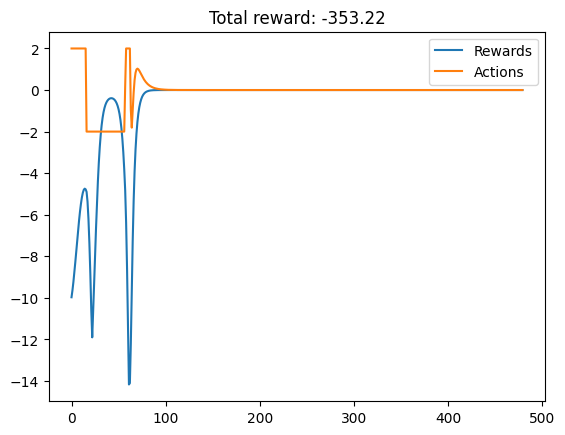

In [ ]:
# Select the hyperparameters
RUN_ITER = 480      # Number of MPC iterations (adjust as needed)
TIMESTEPS = 15     # MPC horizon length
N_BATCH = 1        # Number of parallel batches (1 for a single rollout)
LQR_ITER = 10      # Number of LQR iterations

# Setup the environment
env = gym.make('Pendulum-v1', render_mode='rgb_array')
video_directory = "mpc_videoss"
env = RecordVideo(env, video_directory)
env.reset()  # Reset the underlying environment
env.unwrapped.state = [np.pi, 1]  # Environment must start in downward position

# Define the cost function and initialize u
cost = define_swingup_goal()
u_init = None

# Run MPC
rewards, actions = [], []
for _ in (pbar := trange(RUN_ITER)):
    # Obtain the current state and convert it to a tensor
    state = env.unwrapped.state.copy()
    state = torch.tensor(state, dtype=torch.float32).view(1, -1)

    # Recreate the controller using updated u_init (even though this might be wasteful)
    ctrl = mpc.MPC(2, 1, TIMESTEPS, u_lower=-2.0, u_upper=+2.0,
                   lqr_iter=LQR_ITER, exit_unconverged=False, eps=1e-2,
                   n_batch=N_BATCH, backprop=False, verbose=0, u_init=u_init,
                   grad_method=mpc.GradMethods.AUTO_DIFF)

    # Compute optimal control actions based on the current state, dynamics, and cost
    nominal_states, nominal_actions, nominal_objs = ctrl(state, cost, PendulumDynamics())

    # Take the first planned action
    # nominal_actions has shape (TIMESTEPS, N_BATCH, 1), so extract the first action
    action_tensor = nominal_actions[0]  # shape: (N_BATCH, 1)
    action = action_tensor.item()        # Extract the scalar value (N_BATCH is 1)

    # Update u_init: shift the actions forward and append a zero action at the end
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, N_BATCH, 1)), dim=0)

    # Take a step in the environment using the planned action
    next_state, reward, terminated, truncated, info = env.step([action])

    # Store the latest action and reward
    rewards.append(reward)
    actions.append(action)

    pbar.set_description(f"Action = {actions[-1]:.2f} | Reward = {rewards[-1]:.2f}")
    env.render()

env.close()

# Plot the results
plot_results(rewards, actions)


In [ ]:
# Show the policy learned
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')

# Questions (25 points)

Based on your experiments, answer the following questions:



*   How does the number of LQR iterations affect the MPC?
*   What if we didn't have access to the model dynamics? Could we still use MPC?
*   Do `TIMESTEPS` or `N_BATCH` matter here? Explain.
*   Why do you think we chose to set the initial state of the environment to the downward position?
*   As time progresses (later iterations) what happens to the actions and rewards? Why?

`Your Answers: IS IN PDF`
